In [1]:
import os
import glob
import json
import re
from tld import get_fld
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from IPython.display import HTML
import urllib.parse as parse
import matplotlib.pyplot as plt

In [2]:
# Constants
DATA_DIR = '../crawl_data'
SRC_DIR = '../crawler_src'

In [3]:
# Load the datasets
os.chdir(DATA_DIR)

# Get desktop json files
data_json_desktop = glob.glob('*_desktop.json')

# Get mobile json files
data_json_mobile = glob.glob('*_mobile.json')

In [4]:
def init_data_object():
    return  {
        # Per url data
        'tranco_ranks': [],
        'page_load_times': [],
        'num_requests': [],
        'distinct_third_parties': [],
        'num_distinct_tracker_domains': [],
        'num_distinct_tracker_entities': [],
        
        # Global data
        'failures': {
            'timeout_failures': 0,
            'TLS_failures': 0,
            'consent_failures': 0
        },
        'third_party_counts': {},
        'third_party_tracker_counts': {},
        'third_party_tracker_entities': {},
        'uber_cookie': {
            'request_hostname': '',
            'website': '',
            'num_cookies': 0,
            'first_party': False
        },
        'longest_lifespan_cookies': [],
        'canvas_fingerprints': [],
        'tracker_redirect_combos': []
    }

In [5]:
def parse_stupid_blocklist_to_something_readable(file_path):
    url_list = {}
    
    with open(file_path, encoding='utf-8') as blocklist_file:
        blocklist = json.load(blocklist_file)
        
        for cat, entities in blocklist['categories'].items():
            for entity_list in entities:
                for entity, url_objects in entity_list.items():
                    for url, aliases in url_objects.items():
                        all_urls = [url]
                        all_urls += aliases
                        
                        if entity not in url_list:
                            url_list[entity] = []
                            
                        for u in all_urls:
                            
                            try:
                                url_list[entity].append(get_fld(u, fix_protocol=True))
                            except:
                                pass
                        
                        url_list[entity] = list(set(url_list[entity]))
    
    return url_list

In [6]:
def create_stats_object(json_files):
    data_object = init_data_object()
    
    for json_file in tqdm(json_files):
        with open(json_file, 'r', encoding='utf-8') as data_file:
            try:
                data = json.load(data_file)
            except:
                print(f'Error opening json file: {json_file}, skipping')
                data_object['failures']['timeout_failures'] += 1
                continue
                
            # Updata failure counts
            if data['failure_status']['timeout']:
                data_object['failures']['timeout_failures'] += 1
            if data['failure_status']['TLS'] != 'null':
                data_object['failures']['TLS_failures'] += 1
            if data['failure_status']['consent']:
                data_object['failures']['consent_failures'] += 1
                
            # Only proceed if there is no timeout
            if data['failure_status']['timeout']:
                continue
                
             # Append tranco rank
            data_object['tranco_ranks'].append(int(data['rank']))
                        
            # Append page load time
            data_object['page_load_times'].append(data['load_time'])
            
            # Append number of requests
            data_object['num_requests'].append(len(data['requests']))
            
            # Append distinct third parties
            def get_fld_websocket(u: str):
                if u.startswith('wss://'):
                    return get_fld(u[6:], fix_protocol=True)
                if re.match('\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', parse.urlparse(u).netloc) is not None:
                    return u
                else:
                    return get_fld(u, fix_protocol=True)
            distinct_third_parties = set([ get_fld_websocket(d['request_url'])
                                           for d in data['requests']
                                         ])
            distinct_third_parties.remove(get_fld(data['website_domain'], fix_protocol=True))
            data_object['distinct_third_parties'].append(len(distinct_third_parties))
            
            # Append number of distinct tracker domains
            tracker_dict = parse_stupid_blocklist_to_something_readable(SRC_DIR + '/disconnectmeblocklist.json')
            distinct_tracker_domains = []
            for third_party_domain in distinct_third_parties:
                for _, domains in tracker_dict.items():
                    if third_party_domain in domains:
                        distinct_tracker_domains.append(third_party_domain)
            data_object['num_distinct_tracker_domains'].append(len(distinct_tracker_domains))
            
            # Append number of distinct tracker entities/companies
            distinct_tracker_entities = []
            with open(SRC_DIR + '/domain_map.json', encoding='utf-8') as domain_map_json_file:
                domain_map_json = json.load(domain_map_json_file)
                
                for tracker_domain in distinct_tracker_domains:
                    if tracker_domain in domain_map_json.keys():
                        distinct_tracker_entities.append(domain_map_json[tracker_domain]['entityName'])
                    else:
                        for tracker_entity, tracker_entity_domains in tracker_dict.items():
                            if tracker_domain in tracker_entity_domains:
                                distinct_tracker_entities.append(tracker_entity)
                                break
                
            distinct_tracker_entities = set(distinct_tracker_entities)
            data_object['num_distinct_tracker_entities'].append(len(distinct_tracker_entities))
            
            # Update third party reference counts
            for party in distinct_third_parties:
                if party in data_object['third_party_counts']:
                    data_object['third_party_counts'][party] += 1
                else:
                    data_object['third_party_counts'][party] = 1
            
            # Update third party tracker counts
            for tracker in distinct_tracker_domains:
                if tracker in data_object['third_party_tracker_counts']:
                    data_object['third_party_tracker_counts'][tracker] += 1
                else:
                    data_object['third_party_tracker_counts'][tracker] =1
            
            # Update third party tracker entities
            for entity in distinct_tracker_entities:
                if entity in data_object['third_party_tracker_entities']:
                    data_object['third_party_tracker_entities'][entity] += 1
                else:
                    data_object['third_party_tracker_entities'][entity] =1
                    
            # Update the uber cookie
            max_cookie_count = None
            request_url = None
            for request in data['requests']:
                if 'cookie' not in request['request_headers']:
                    continue
                    
                cookie_count = len(request['request_headers']['cookie'].split(';'))
                if max_cookie_count is None or cookie_count > max_cookie_count:
                    max_cookie_count = cookie_count
                    request_url = request['request_url']
            
            if max_cookie_count is not None and \
               max_cookie_count > data_object['uber_cookie']['num_cookies']:
                data_object['uber_cookie']['num_cookies'] = max_cookie_count
                data_object['uber_cookie']['request_hostname'] = get_fld(request_url, fix_protocol=True)
                data_object['uber_cookie']['website'] = data['website_domain']
                data_object['uber_cookie']['first_party'] = data_object['uber_cookie']['request_hostname'] == \
                                                            data_object['uber_cookie']['website']
                
            # Get longest lasting cookies
            cookie_ids = []
            for request in data['requests']:
                if 'cookie' not in request['request_headers']:
                    continue
                    
                cookies = request['request_headers']['cookie'].split(';')
                for cookie in cookies:
                    cookie_ids.append(cookie.split('=')[0])
            
            all_cookies = []
            for cookie in data['cookies']:
                if cookie['name'] in cookie_ids:
                    cookie_data = cookie.copy()
                    cookie_data['size'] = len(cookie_data['value'])
                    
                    if 'sameSite' not in cookie_data:
                        cookie_data['sameSite'] = None

                    if 'expiry' not in cookie_data: # Cookies without expiry exist
                        cookie_data['expiry'] = 999999999999999
                    all_cookies.append(cookie_data)
                    all_cookies.append(cookie_data)

            sort_alg = lambda c: c['expiry']
            all_cookies.sort(key=sort_alg, reverse=True)
            data_object['longest_lifespan_cookies'] += all_cookies[:3]
            data_object['longest_lifespan_cookies'].sort(key=sort_alg, reverse=True)
            data_object['longest_lifespan_cookies'] = data_object['longest_lifespan_cookies'][:3]
            
            # HTTP redirect pairs for tracker domains
            tracker_redirect_combos = []
            for request in data['requests']:
                if request['response_status_code'] >= 300 and \
                   request['response_status_code'] <= 399 and \
                   'location' in request['response_headers']:
                    origin_domain = get_fld(request['request_url'], fix_protocol=True)
                    if request['response_headers']['location'].startswith('http'): # TODO: verify this filters exactly all non-relative URLs
                        redirect_domain = get_fld(request['response_headers']['location'], fix_protocol=True)
                    else: # location can be relative URL
                        redirect_domain = origin_domain
                    if origin_domain != redirect_domain and \
                       (origin_domain in distinct_tracker_domains or \
                        redirect_domain in distinct_tracker_domains):
                        tracker_redirect_combos.append((origin_domain, redirect_domain))
            data_object['tracker_redirect_combos'] += list(set(tracker_redirect_combos))
            
            # Fingerprints
            for fingerprint in data['canvas_image_data']:
                fingerprint['website'] = get_fld(data['website_domain'], fix_protocol=True)
            data_object['canvas_fingerprints'] += data['canvas_image_data']
            
    return data_object

In [7]:
# Create the data objects
crawls = {
    'desktop': create_stats_object(data_json_desktop),
    'mobile': create_stats_object(data_json_mobile)
}

100%|█████████████████████████████████████████████████████████████| 480/480 [00:34<00:00, 13.91it/s]


In [8]:
def get_url_df(crawl_data):
    slice_keys = ['tranco_ranks', 'page_load_times', 'num_requests', 'distinct_third_parties',
              'num_distinct_tracker_domains', 'num_distinct_tracker_entities']
    df_input = {k: v for k, v in crawl_data.items() if k in slice_keys}
    return pd.DataFrame(data=df_input)

df_desktop = get_url_df(crawls['desktop'])
df_mobile = get_url_df(crawls['mobile'])

In [9]:
#1
desktop_failures = {'Page load timeout': crawls['desktop']['failures']['timeout_failures'],
                    'TLS error': crawls['desktop']['failures']['TLS_failures'],
                    'Consent click error': crawls['desktop']['failures']['consent_failures']}

mobile_failures = {'Page load timeout': crawls['mobile']['failures']['timeout_failures'],
                    'TLS error': crawls['mobile']['failures']['TLS_failures'],
                    'Consent click error': crawls['mobile']['failures']['consent_failures']}

failures_table = pd.DataFrame({'Crawl-desktop': desktop_failures, 'Crawl-mobile': mobile_failures})
failures_table.columns.name = 'Error type'

print(failures_table.to_latex())

\begin{tabular}{lrr}
\toprule
Error type &  Crawl-desktop &  Crawl-mobile \\
\midrule
Page load timeout   &            325 &           301 \\
TLS error           &            477 &           480 \\
Consent click error &              0 &             0 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_295762/3454660435.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(failures_table.to_latex())


In [10]:
#2
def draw_boxplot(metric):
    box_df = pd.DataFrame(df_desktop, columns=[metric])
    box_df.rename(columns={metric:'Crawl-desktop'}, inplace=True)
    box_df = box_df.join(df_mobile[metric])
    box_df.rename(columns={metric:'Crawl-mobile'}, inplace=True)
    return sns.boxplot(data=pd.DataFrame(data=box_df, columns=['Crawl-desktop','Crawl-mobile']))

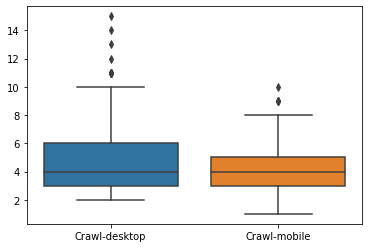

In [11]:
g_pageload = draw_boxplot('page_load_times')
plt.savefig('../plots/figure2_pageload.png', dpi=600)

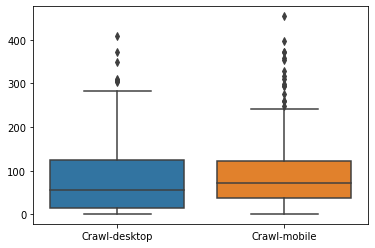

In [12]:
g_requests = draw_boxplot('num_requests')
plt.savefig('../plots/figure2_requests.png', dpi=600)

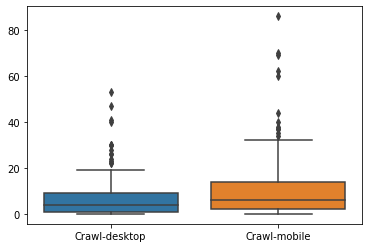

In [13]:
g_thirdparties = draw_boxplot('distinct_third_parties')
plt.savefig('../plots/figure2_thirdparties.png', dpi=600)

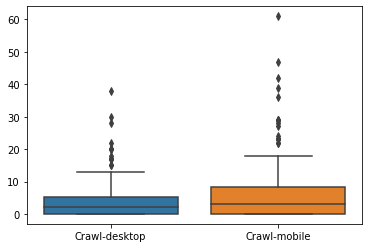

In [14]:
g_trackdomains = draw_boxplot('num_distinct_tracker_domains')
plt.savefig('../plots/figure2_trackdomains.png', dpi=600)

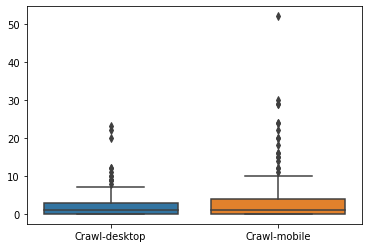

In [15]:
g_trackentities = draw_boxplot('num_distinct_tracker_entities')
plt.savefig('../plots/figure2_entities.png', dpi=600)

In [16]:
#3
# Create desktop lookup and mobile lookup to make table string legible code.
dlu = {'plt': df_desktop['page_load_times'],
       'nr': df_desktop['num_requests'],
       'dtp': df_desktop['distinct_third_parties'],
       'dtd': df_desktop['num_distinct_tracker_domains'],
       'dte': df_desktop['num_distinct_tracker_entities']}
mlu = {'plt': df_mobile['page_load_times'],
       'nr': df_mobile['num_requests'],
       'dtp': df_mobile['distinct_third_parties'],
       'dtd': df_mobile['num_distinct_tracker_domains'],
       'dte': df_mobile['num_distinct_tracker_entities']}
table=f"""\\begin{{tabular}}{{l|l l l l l l }}
        \\toprule
        & \multicolumn{{3}}{{c|}}{{Crawl-desktop}} & \multicolumn{{3}}{{c|}}{{Crawl-mobile}} \\\\ \\hline
        \\textbf{{Metric}} & \t\t\tMin & Max & Median & Min & Max & Median \\\\
        \midrule
        Page load time (s) & \t\t\t{dlu['plt'].min()} & {dlu['plt'].max()} & {dlu['plt'].median()} & {mlu['plt'].min()} & {mlu['plt'].max()} & {mlu['plt'].median()} \\\\
        Number of requests & \t\t\t{dlu['nr'].min()} & {dlu['nr'].max()} & {dlu['nr'].median()} & {mlu['nr'].min()} & {mlu['nr'].max()} & {mlu['nr'].median()} \\\\
        Number of distinct third parties & \t{dlu['dtp'].min()} & {dlu['dtp'].max()} & {dlu['dtp'].median()} & {mlu['dtp'].min()} & {mlu['dtp'].max()} & {mlu['dtp'].median()} \\\\
        Number of distinct tracker domains & \t{dlu['dtd'].min()} & {dlu['dtd'].max()} & {dlu['dtd'].median()} & {mlu['dtd'].min()} & {mlu['dtd'].max()} & {mlu['dtd'].median()} \\\\
        Number of distinct tracker entities & \t{dlu['dte'].min()} & {dlu['dte'].max()} & {dlu['dte'].median()} & {mlu['dte'].min()} & {mlu['dte'].max()} & {mlu['dte'].median()} \\\\
        \\bottomrule
    \end{{tabular}}"""
print(table)

\begin{tabular}{l|l l l l l l }
        \toprule
        & \multicolumn{3}{c|}{Crawl-desktop} & \multicolumn{3}{c|}{Crawl-mobile} \\ \hline
        \textbf{Metric} & 			Min & Max & Median & Min & Max & Median \\
        \midrule
        Page load time (s) & 			2.0 & 15.0 & 4.0 & 1.0 & 10.0 & 4.0 \\
        Number of requests & 			1 & 409 & 55.5 & 1 & 454 & 71.0 \\
        Number of distinct third parties & 	0 & 53 & 4.0 & 0 & 86 & 6.0 \\
        Number of distinct tracker domains & 	0 & 38 & 2.0 & 0 & 61 & 3.0 \\
        Number of distinct tracker entities & 	0 & 23 & 1.0 & 0 & 52 & 1.0 \\
        \bottomrule
    \end{tabular}


In [17]:
def ten_most_prev_websites_table(desktop_counts, mobile_counts):
    table_desktop = pd.DataFrame({'Third-party desktop': desktop_counts.keys(), 'Nr of websites desktop': desktop_counts.values()}).sort_values(by=['Nr of websites desktop'],ascending=False).reset_index(drop=True)
    table_mobile = pd.DataFrame({'Third-party mobile': mobile_counts.keys(), 'Nr of websites mobile': mobile_counts.values()}).sort_values(by=['Nr of websites mobile'],ascending=False).reset_index(drop=True)

    table = pd.concat([table_desktop, table_mobile],axis=1)

    # Some settings to make the table prettier
    pd.set_option('display.precision', 0) # No decimals in count
    pd.set_option('expand_frame_repr', False)
    table.index += 1 # Start at index 1
    columns=[('Crawl-desktop','Third-party'),('Crawl-desktop','Number of websites'),('Crawl-mobile','Third-party'),('Crawl-mobile','Number of websites') ]
    table.columns=pd.MultiIndex.from_tuples(columns) # Add nested column names
    return table
    #Only print the first 10 rows

In [18]:
#4
print(ten_most_prev_websites_table(crawls['desktop']['third_party_counts'], crawls['mobile']['third_party_counts']).head(10).to_latex(index=False))

\begin{tabular}{lrlr}
\toprule
       Crawl-desktop & \multicolumn{2}{l}{Crawl-mobile} \\
         Third-party & Number of websites &          Third-party & Number of websites \\
\midrule
          google.com &                 49 &           google.com &                 77 \\
     doubleclick.net &                 43 &      doubleclick.net &                 68 \\
google-analytics.com &                 41 & google-analytics.com &                 67 \\
         gstatic.com &                 38 & googletagmanager.com &                 62 \\
googletagmanager.com &                 38 &            google.nl &                 54 \\
           google.nl &                 34 &         facebook.com &                 42 \\
        facebook.com &                 23 &          gstatic.com &                 36 \\
googleadservices.com &                 20 & googleadservices.com &                 34 \\
fonts.googleapis.com &                 19 &         facebook.net &                 33 \\
        fac

/tmp/ipykernel_295762/1593062785.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ten_most_prev_websites_table(crawls['desktop']['third_party_counts'], crawls['mobile']['third_party_counts']).head(10).to_latex(index=False))


In [19]:
#5
print(ten_most_prev_websites_table(crawls['desktop']['third_party_tracker_counts'], crawls['mobile']['third_party_tracker_counts']).head(10).to_latex(index=False))

\begin{tabular}{lrlr}
\toprule
        Crawl-desktop & \multicolumn{2}{l}{Crawl-mobile} \\
          Third-party & Number of websites &          Third-party & Number of websites \\
\midrule
           google.com &                 49 &           google.com &                 77 \\
      doubleclick.net &                 43 &      doubleclick.net &                 68 \\
 google-analytics.com &                 41 & google-analytics.com &                 67 \\
          gstatic.com &                 38 &            google.nl &                 54 \\
            google.nl &                 34 &         facebook.com &                 42 \\
         facebook.com &                 23 &          gstatic.com &                 36 \\
 googleadservices.com &                 20 & googleadservices.com &                 34 \\
         facebook.net &                 18 &         facebook.net &                 33 \\
             bing.com &                 14 &          twitter.com &                 23 \\


/tmp/ipykernel_295762/2574018179.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ten_most_prev_websites_table(crawls['desktop']['third_party_tracker_counts'], crawls['mobile']['third_party_tracker_counts']).head(10).to_latex(index=False))


In [20]:
#6
print(ten_most_prev_websites_table(crawls['desktop']['third_party_tracker_entities'], crawls['mobile']['third_party_tracker_entities']).head(10).to_latex(index=False))

\begin{tabular}{lrlr}
\toprule
            Crawl-desktop & \multicolumn{2}{l}{Crawl-mobile} \\
              Third-party & Number of websites &               Third-party & Number of websites \\
\midrule
               Google LLC &                 75 &                Google LLC &                103 \\
           Facebook, Inc. &                 26 &            Facebook, Inc. &                 46 \\
    Microsoft Corporation &                 22 &     Microsoft Corporation &                 38 \\
            comScore, Inc &                 13 &                Adobe Inc. &                 26 \\
Amazon Technologies, Inc. &                 13 &             Twitter, Inc. &                 24 \\
            Twitter, Inc. &                 12 & Amazon Technologies, Inc. &                 20 \\
               Adobe Inc. &                 11 &        The Trade Desk Inc &                 17 \\
         Cloudflare, Inc. &                 11 &          WarnerMedia, LLC &                 16 \\
     

/tmp/ipykernel_295762/3737735225.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ten_most_prev_websites_table(crawls['desktop']['third_party_tracker_entities'], crawls['mobile']['third_party_tracker_entities']).head(10).to_latex(index=False))


In [21]:
#7 prep dataframes for plots
distinct_third_parties_desktop = pd.DataFrame( {'Tranco rank': crawls['desktop']['tranco_ranks'], 'Distinct third-party domains': crawls['desktop']['distinct_third_parties']})
distinct_third_parties_mobile = pd.DataFrame( {'Tranco rank': crawls['mobile']['tranco_ranks'], 'Distinct third-party domains': crawls['mobile']['distinct_third_parties']})

# TODO: remove NaN values

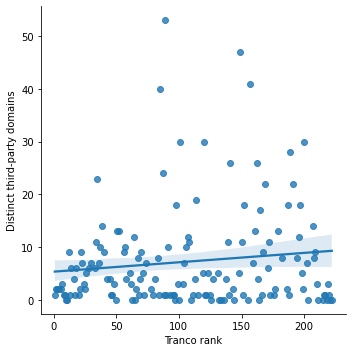

In [22]:
#7 desktop
sns.lmplot(x='Tranco rank', y='Distinct third-party domains', data=distinct_third_parties_desktop)
plt.savefig('../plots/figure7_desktop.png', dpi=600)

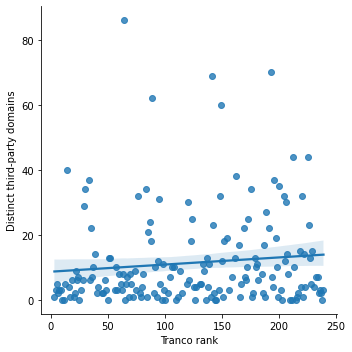

In [23]:
#7 mobile
sns.lmplot(x='Tranco rank', y='Distinct third-party domains', data=distinct_third_parties_mobile)
plt.savefig('../plots/figure7_mobile.png', dpi=600)

In [24]:
#8
distinct_trackers_desktop = pd.DataFrame( {'Tranco rank': crawls['desktop']['tranco_ranks'], 'Distinct tracker domains': crawls['desktop']['num_distinct_tracker_domains']})
distinct_trackers_mobile = pd.DataFrame( {'Tranco rank': crawls['mobile']['tranco_ranks'], 'Distinct tracker domains': crawls['mobile']['num_distinct_tracker_domains']})

# TODO: remove NaN values

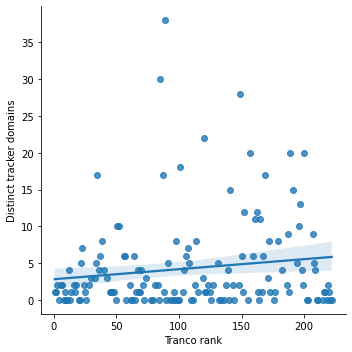

In [25]:
#8 desktop
sns.lmplot(x='Tranco rank', y='Distinct tracker domains', data=distinct_trackers_desktop)
plt.savefig('../plots/figure8_desktop.png', dpi=600)

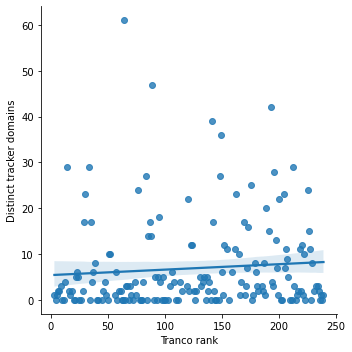

In [26]:
#8 mobile
sns.lmplot(x='Tranco rank', y='Distinct tracker domains', data=distinct_trackers_mobile)
plt.savefig('../plots/figure8_mobile.png', dpi=600)

In [27]:
#9
data_9 = []
for crawl, crawl_data in crawls.items():
    data_9.append([crawl] + list(crawl_data['uber_cookie'].values()))
    
df_9 = pd.DataFrame(data_9)
df_9.columns = ['crawl'] + list(crawls['desktop']['uber_cookie'].keys())
print(df_9.to_latex(index=False))

\begin{tabular}{lllrl}
\toprule
  crawl & request\_hostname & website &  num\_cookies &  first\_party \\
\midrule
desktop &          cdc.gov & cdc.gov &           18 &         True \\
 mobile &          cdc.gov & cdc.gov &           18 &         True \\
\bottomrule
\end{tabular}



/tmp/ipykernel_295762/290853184.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_9.to_latex(index=False))


In [28]:
#10
data_10 = []
for crawl, crawl_data in crawls.items():
    for cookie in crawl_data['longest_lifespan_cookies']:
        data_10.append([crawl] + list(cookie.values()))

df_10 = pd.DataFrame(data_10)
df_10.columns = ['crawl'] + list(crawls['desktop']['longest_lifespan_cookies'][0].keys())
print(df_10.to_latex(index=False))

\begin{tabular}{llllllllrr}
\toprule
  crawl &             domain &  httpOnly &        name & path & sameSite & secure &                                value &  size &          expiry \\
\midrule
desktop &     www.office.com &      True &      OH.SID &    / &     None &   True & 30e97afa-8701-4be9-9592-7c5ff9f94144 &    36 & 999999999999999 \\
desktop &     www.office.com &      True &      OH.SID &    / &     None &   True & 30e97afa-8701-4be9-9592-7c5ff9f94144 &    36 & 999999999999999 \\
desktop & www.slideshare.net &     False &    language &    / &    False &     ** &                                    2 &   NaN & 999999999999999 \\
 mobile &           .cnn.com &     False & countryCode &    / &     None &   True &                                   NL &     2 & 999999999999999 \\
 mobile &           .cnn.com &     False & countryCode &    / &     None &   True &                                   NL &     2 & 999999999999999 \\
 mobile &           .zoom.us &      True &    \_zm\_ss

/tmp/ipykernel_295762/3595616902.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_10.to_latex(index=False))


In [29]:
#11
data_11 = []
for crawl, crawl_data in crawls.items():
    for combo in crawl_data['tracker_redirect_combos']:
        data_11.append([crawl, combo[0], combo[1]])
                
df_11 = pd.DataFrame(data_11)
df_11.columns = ['crawl', 'source hostname', 'target hostname']
df_11 = df_11.groupby(['crawl','source hostname', 'target hostname'])['target hostname'] \
         .count() \
         .reset_index(name="Number of distinct websites") \
         .sort_values(['crawl', 'Number of distinct websites'], ascending=False)
df_11 = pd.concat([df_11[df_11['crawl'] == 'desktop'].head(10),
                   df_11[df_11['crawl'] == 'mobile'].head(10)])
print(df_11.to_latex(index=False))

\begin{tabular}{lllr}
\toprule
  crawl & source hostname &     target hostname &  Number of distinct websites \\
\midrule
desktop &        bing.com &          clarity.ms &                            6 \\
desktop &      clarity.ms &            bing.com &                            6 \\
desktop & doubleclick.net &          google.com &                            5 \\
desktop & doubleclick.net &     casalemedia.com &                            3 \\
desktop &      google.com &           google.nl &                            3 \\
desktop &      adsrvr.org &           ml314.com &                            2 \\
desktop &   crwdcntrl.net &           ml314.com &                            2 \\
desktop &    facebook.com &           fbcdn.net &                            2 \\
desktop &       fbcdn.net &           fbsbx.com &                            2 \\
desktop &      google.com &     doubleclick.net &                            2 \\
 mobile & doubleclick.net &          google.com &         

/tmp/ipykernel_295762/1741706668.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_11.to_latex(index=False))


In [30]:
#12
canvas_fingerprints = []
for crawl, crawl_data in crawls.items():
    for fingerprint in crawl_data['canvas_fingerprints']:
        canvas_fingerprints.append([crawl,
                                    fingerprint['website'],
                                    fingerprint['fingerprint_script_resource_url'],
                                    '<img src="' + DATA_DIR + '/' + fingerprint['canvas_fingerprint_image'] + '" />'
                                   ])
df_canvas_fingerprints = pd.DataFrame(canvas_fingerprints)
df_canvas_fingerprints.columns = ['Crawl', 'Website', 'Fingerprint script URL', 'Canvas image']
df_canvas_fingerprints = df_canvas_fingerprints.to_html(escape=False)
HTML(df_canvas_fingerprints)

,Crawl,Website,Fingerprint script URL,Canvas image
0,desktop,jd.com,https://gias.jd.com/js/td.js:1:1,
1,desktop,ibm.com,https://www.ibm.com/GXcMX0/j/b/-_35Yf5Gu3Ah/zupODGJDruOr/AHckAWsB/DSQlc/HhjXjE:1:80389,
2,desktop,ibm.com,https://www.ibm.com/GXcMX0/j/b/-_35Yf5Gu3Ah/zupODGJDruOr/AHckAWsB/DSQlc/HhjXjE:1:80389,
3,desktop,baidu.com,https://hectorstatic.baidu.com/96c9c06653ba892e.js:3:1378,
4,desktop,discord.com,https://discord.com/cdn-cgi/bm/cv/669835187/api.js:25:7216,
5,desktop,zhihu.com,https://static.zhihu.com/heifetz/main.zswsdid.ef1d4d1122c5d73d3e09.js:1:16962,
6,desktop,zhihu.com,https://cstaticdun.126.net/2.17.4/core.v2.17.4.min.js?v=2756422:1:423506,
7,desktop,zhihu.com,https://acstatic-dun.126.net/2.7.5_602a5ad7/watchman.min.js:151:496,
8,desktop,canva.com,https://canva.com/cdn-cgi/bm/cv/669835187/api.js:25:7216,
9,desktop,bloomberg.com,https://www.bloomberg.com/8FCGYgk4/init.js:4:14392,


In [32]:
#12 latex version
canvas_fingerprints = []
for crawl, crawl_data in crawls.items():
    for fingerprint in crawl_data['canvas_fingerprints']:
        canvas_fingerprints.append([crawl,
                                    fingerprint['website'],
                                    fingerprint['fingerprint_script_resource_url'],
                                    '\includegraphics[]{fingerprints/' + fingerprint['canvas_fingerprint_image'] + '}'
                                   ])
df_canvas_fingerprints = pd.DataFrame(canvas_fingerprints)
df_canvas_fingerprints.columns = ['Crawl', 'Website', 'Fingerprint script URL', 'Canvas image']
pd.options.display.max_colwidth=100
print(df_canvas_fingerprints.to_latex(index=False))

\begin{tabular}{llll}
\toprule
  Crawl &       Website &                                                                               Fingerprint script URL &                                                                Canvas image \\
\midrule
desktop &        jd.com &                                                                     https://gias.jd.com/js/td.js:1:1 &        \textbackslash includegraphics[]\{fingerprints/jd.com\_desktop\_canvas\_capture\_0.png\} \\
desktop &       ibm.com &               https://www.ibm.com/GXcMX0/j/b/-\_35Yf5Gu3Ah/zupODGJDruOr/AHckAWsB/DSQlc/HhjXjE:1:80389 &       \textbackslash includegraphics[]\{fingerprints/ibm.com\_desktop\_canvas\_capture\_0.png\} \\
desktop &       ibm.com &               https://www.ibm.com/GXcMX0/j/b/-\_35Yf5Gu3Ah/zupODGJDruOr/AHckAWsB/DSQlc/HhjXjE:1:80389 &       \textbackslash includegraphics[]\{fingerprints/ibm.com\_desktop\_canvas\_capture\_1.png\} \\
desktop &     baidu.com &                                         

/tmp/ipykernel_295762/2094004511.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_canvas_fingerprints.to_latex(index=False))
